# Predicting NCAA March Madness
UW INFO 370: Introduction to Data Science

Final Project 2019

Krishna Puvvada, Travis Neils, Zach Palmer, Paul Winebrenner


## Project Description


### Purpose

The purpose of this project is to discover how machine learning could be applied to college basketball games to predict performance in the NCAA March Madness bracket. Sports generally have long been an area ripe for data analytics, given their many different measurable metric of play, and basketball is no exception with steals, points, assists, and other factors all leading to a win. Our goal with this project is to attempt to reduce a basketball game to its components (like scoring, rebounding, blocks and steals) with the purpose of being able to accurately predict the outcome of a game given a series of inputs.

This research is of particular importance for the sport of basketball as an accurate predictive model would allow teams to not only predict the outcomes of their games, but also to analyze what areas they could improve in to better their results. This would likely have an impact not only on the college (NCAA) level, but also at other levels of the game.

Additionally, this project is important as it explores whether or not sporting events can be predicted with any level of accuracy. Sports have long been elusive to predict, hence the strong gambling market surrounding them. The combination of skill and luck makes sports by nature difficult to predict. Nowhere is this better evidence than the NCAA tournament. Each year, 68 teams compete for a national title. The teams, selected and seeded by a special committee, are drawn from the 351 Division 1 college basketball teams. Nominally, the committee selects teams based on factors including but not limited to: wins, strength of schedule, conference record and, &quot;various computer metrics&quot;. All of these factors are based on regular season play. Once in the tournament, teams play against each other until a national champion is crowned (67 games total). Assuming that the odds of picking a game correctly are .5 (½), the odds of getting every single game correct in the tournament is 6.7762636e-21. Obviously, those odds are not great. As such, our mission is to attempt to create a series of algorithms that allow us to use both regular season statistics, and information about seeding, to predict NCAA Tournament games with better accuracy.

### Data

In order to analyze how machine learning could be used to predict the outcome of college basketball games, we had to narrow down our approach and variables to a reasonable size. We decided to use invididual game data for each season to train our model obtained from [Kaggle](https://www.kaggle.com/c/mens-machine-learning-competition-2019/data). For every game in the regular season, the dataset recorded the field goals made, field goals attempted, three pointers made, three pointers attempted, free throws made, free throws attempted, offensive rebounds, defensive rebounds, assists, turnovers committed, steals, blocks, and personal fouls committed, as well as the final score. Since March Madness is notorious for upsets that are very difficult to predict, we thought it was best to reduce the dataset to its lowest level and focus on how we could predict an outcome of a game based on the game stats that any given team has, as well as their seed in the playoff bracket. If we can predict a game's score based on this collection of variables, we can then use that model to predict the NCAA bracket game by game using the season's aggregate data. 

To get an idea on which variables might be the most impactful for our final predictions, we created a correlation graph between the different game variables and total points scored by the winning team below: 


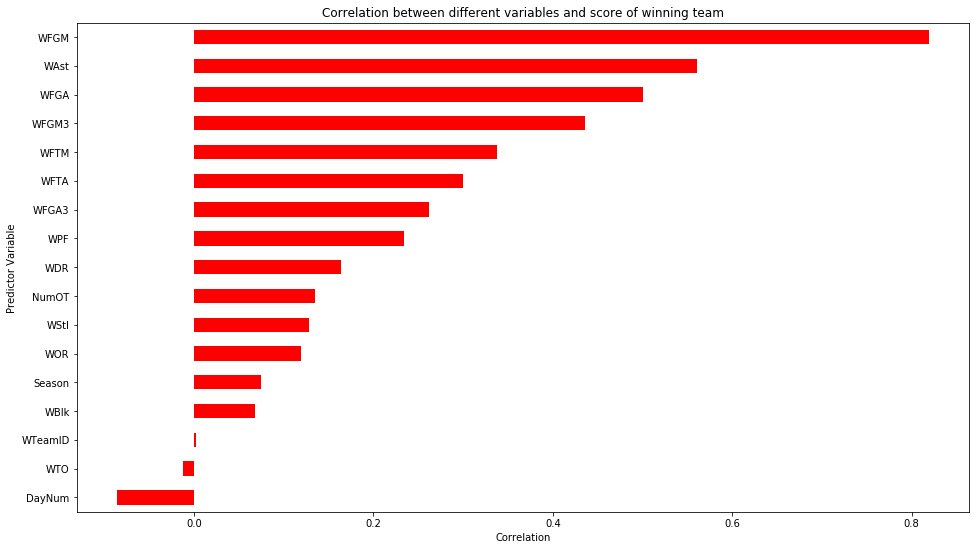

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import KFold

results = pd.read_csv('data/RegularSeasonDetailedResults.csv')
teams = pd.read_csv('data/Teams.csv')

# Get only winning teams game stats to predict their score
resultsWin = results.drop(['LTeamID', 'LScore', 'WLoc', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3', 'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'], axis=1)

winCorr = resultsWin.corr()

plt.figure(figsize=(16,9))
plt.xlabel('Correlation')
plt.ylabel('Predictor Variable')
plt.title('Correlation between different variables and score of winning team')
(winCorr
    .WScore
    .drop('WScore')
    .sort_values(ascending=True)
    .plot
    .barh(color='red')
)

To see if similar variables would be correlated for the losing teams, we included a correlation graph below for the losing team: 

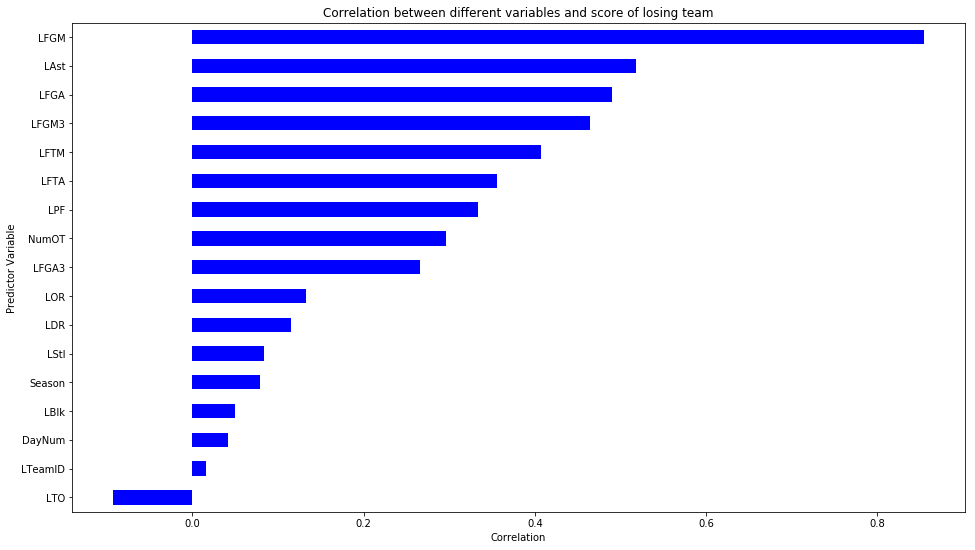

In [8]:
resultsLoss = results.drop(['WTeamID', 'WScore', 'WLoc', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR', 'WAst', 'WTO', 'WStl', 'WBlk', 'WPF'], axis=1)

lossCorr = resultsLoss.corr()

plt.figure(figsize=(16,9))
plt.xlabel('Correlation')
plt.ylabel('Predictor Variable')
plt.title('Correlation between different variables and score of losing team')
(lossCorr
    .LScore
    .drop('LScore')
    .sort_values(ascending=True)
    .plot
    .barh(color='blue')
)

The highest correlated variables across both types of teams are field goals made, assists, and field goals attempted, which makes sense since field goals are the most common shots to make in earning points for a team. With our most correlated variables, the next step is to figure out how to best leverage them to predict the outcome of games based on them.

### Machine Learning

To leverage machine learning techniques to enhance our predictions, we used a neural network to test our hypothesis that certain features of the NCAA teams dataset would be positively correlated to wins and bracket standings. Sport prediction is usually treated as a classification problem, with one class, win, lose, or draw, to be predicted. The aim of classification is to predict a target variable, or class, by building a classification model based on a training dataset, and then utilizing that model to predict the value of the class of test data. An artificial neural network usually contains interconnected components called neurons that transform a set of inputs into a desired output, mimicking the neural structure of the human brain. A neural network can dynamically adjust the weights given to certain features when building the classification model and is thus able to accomplish high levels of predictive accuracy. While this constant changing of weights might have complications due to overfitting or computational complexity, neural networks are still very flexible and would fit a model such as the NCAA due to the large amounts of different predictive variables.

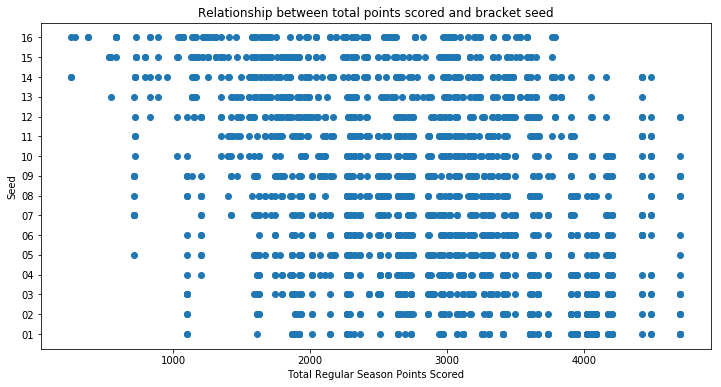

In [66]:
seeds = pd.read_csv('data/NCAATourneySeeds.csv')
compact = pd.read_csv('data/RegularSeasonCompactResults.csv')

# make composite table of all season stats
defStats = compact.loc[compact['Season'] == 2018]
TeamStats = defStats.groupby('WTeamID').sum()
#print(TeamStats)
TeamStats['totalScore'] = TeamStats['WScore'] + TeamStats['LScore']
TeamStats = TeamStats.drop(columns=['DayNum', 'Season', 'WScore', 'LTeamID', 'LScore', 'NumOT'])
TeamStats.reset_index(level=0, inplace=True)
TeamStats.columns = ['TeamID', 'totalScore']
TeamStats = TeamStats.merge(seeds, on='TeamID')
TeamStats = TeamStats.sort_values(by=['Seed'])

def removeChars(seed):
    return re.sub('[^0-9]','', seed)

TeamStats['Seed'] = TeamStats['Seed'].apply(removeChars)


plt.figure(figsize=(12,6))
plt.xlabel('Total Regular Season Points Scored')
plt.ylabel('Seed')
plt.title('Relationship between total points scored and bracket seed')
plt.scatter(TeamStats['totalScore'], TeamStats['Seed'])